In [1]:
!rm -rf InkubaLM-Challenge
!git clone https://github.com/melissafasol/InkubaLM-Challenge.git
%cd InkubaLM-Challenge


Cloning into 'InkubaLM-Challenge'...
remote: Enumerating objects: 370, done.
remote: Counting objects: 100% (195/195), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 370 (delta 143), reused 121 (delta 86), pack-reused 175 (from 1)
Receiving objects: 100% (370/370), 1.37 MiB | 18.74 MiB/s, done.
Resolving deltas: 100% (242/242), done.
/content/InkubaLM-Challenge


In [2]:
%cd InkubaLM-Challenge
!git pull


[Errno 2] No such file or directory: 'InkubaLM-Challenge'
/content/InkubaLM-Challenge
Already up to date.


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
!pip install -U trl bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
!pip install datasets

In [6]:
import sys
from pathlib import Path


import os
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from datasets import (
    load_dataset,
    concatenate_datasets,
    Dataset,
    Value
)
from huggingface_hub import login
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig
)
from peft import (
    LoraConfig,
    get_peft_model,
    PeftModel
)
from trl import (
    SFTConfig,
    SFTTrainer,
    DataCollatorForCompletionOnlyLM
)

from utils import (
    eval,
    model_function,
    supplement,
    multitask,
    ab_testing
)


In [7]:
from google.colab import drive
drive.mount('/content/drive')
output_path = "/content/drive/MyDrive/InkubaLM-Challenge/Output"
os.makedirs(output_path, exist_ok=True)

Mounted at /content/drive


In [8]:
from huggingface_hub import login

try:
    from google.colab import userdata
    os.environ["hf_token_2"] = userdata.get("hf_token_2")
except:
    os.environ["hf_token_2"] = "----"

login(token=os.environ["hf_token_2"])

token = os.environ["hf_token_2"]
if token == "----":
    print("⚠️ Warning: No Hugging Face token found. Some models may not load.")
else:
    login(token=token)

In [11]:
hf_token_2 = '...'
os.environ["HF_TOKEN"] = hf_token_2

## **Load and Explore Datasets**

In [26]:
print("# Loading datasets")
se_dataset, mt_dataset,xn_dataset = multitask.load_and_combine_datasets("Train")
test_dataset = multitask.load_and_combine_datasets("Test")


# Loading datasets
All Columns: ['premise', 'data_source', 'langs', 'task', 'ID', 'inputs', 'targets', 'instruction']
All Columns: ['premise', 'data_source', 'langs', 'task', 'ID', 'inputs', 'targets', 'instruction']


In [33]:
combined_dataset = concatenate_datasets([se_dataset, mt_dataset, xn_dataset])
train_df = combined_dataset.to_pandas()

# **Data Augmentation**

###**Problem:** sentiment analysis classes are heavily skewed towards neutral class for Swahili.

### **Solution**: supplement dataset with various augmentation techniques:
- **synonym replacement**
- **random swap**
- **random deletion** (produces data that is more similar to social media posts)

In [35]:
from transformers import AutoTokenizer
import numpy as np
import pandas as pd

def balance_target_lengths(df, tokenizer, task_column='task', text_column='targets'):
    """
    Balances target token counts across tasks by repeating rows from low-token tasks.

    Args:
        df (DataFrame): Input DataFrame with 'task' and 'targets'
        tokenizer (transformers tokenizer): Tokenizer to count tokens
        task_column (str): Column with task names
        text_column (str): Column with target texts

    Returns:
        DataFrame: Balanced DataFrame
    """
    # Compute average token lengths per task
    df['target_len'] = df[text_column].apply(lambda x: len(tokenizer(x).input_ids))

    # Total token count per task
    task_tokens = df.groupby(task_column)['target_len'].sum()

    # Find the task with the highest total tokens
    max_tokens = task_tokens.max()

    balanced_dfs = []
    for task, group in df.groupby(task_column):
        repeat_factor = int(np.ceil(max_tokens / task_tokens[task]))
        repeated = pd.concat([group] * repeat_factor, ignore_index=True)
        balanced_dfs.append(repeated)

    balanced_df = pd.concat(balanced_dfs, ignore_index=True).drop(columns='target_len')
    return balanced_df


In [48]:
import re

def extract_task_from_id(id_str):
    match = re.search(r'afrixnli|mt|sentiment', id_str)
    return match.group(0) if match else None

train_df['task'] = train_df['ID'].apply(extract_task_from_id)



In [52]:
train_df

,ID,task,langs,data_source,instruction,inputs,targets,premise,target_len
0,ID_6aba33a1_sentiment_ dev_hausa,sentiment,hausa,afrisenti,Za ka iya tantance yanayin wannan rubutu? Bi w...,@user @user allah ya tsayyaba yar uwa 🎂 😍,Kyakkyawa,,5
1,ID_ce64d307_sentiment_ dev_hausa,sentiment,hausa,naijasenti,Da fatan za a gano ra'ayin da ke cikin wannan ...,@user intenet a masallachi😭😭😭 wani salo ne na ...,Tsaka-tsaki,,6
2,ID_dfb02831_sentiment_ dev_swahili,sentiment,swahili,swahili_tweet,Tafadhali tambua mawazo yaliyoonyeshwa kwenye ...,picha mbunge wa kilombero peter lijualikali ak...,Wastani,,3
3,ID_2efc9515_sentiment_ dev_hausa,sentiment,hausa,afrisenti,Gano ra'ayin da aka bayyana a cikin wannan rub...,@user @user @user @user @user hhh amma rahama ...,Tsaka-tsaki,,6
4,ID_ad1d9888_sentiment_ dev_swahili,sentiment,swahili,afrisenti,Tafadhali tambua mawazo yaliyoonyeshwa kwenye ...,swali zuri sana nawatafuta wajuzi wa mambo wat...,Wastani,,3
...,...,...,...,...,...,...,...,...,...
1395,ID_085354e1_dev_afrixnli_swa,afrixnli,swa,,"Is the following question True, False or Neither?",Maduka ya habari ya kitaifa hufanya maeneo yet...,1,tahadhari kuhusu jinsi habari za kitaifa zinav...,2
1396,ID_586e104a_dev_afrixnli_swa,afrixnli,swa,,"Is the following question True, False or Neither?",Kurasa zilihusisha wanachama na maafisa wa kaw...,0,Uanachama ulijumuisha kati ya wanaume wazima ...,2
1397,ID_b871ea53_dev_afrixnli_hau,afrixnli,hau,,"Is the following question True, False or Neither?",Ban damu ba da abinda labarun ƙasa ke nuni cik...,2,Ka damu da yadda labarun ƙasa ke shafar unguwa...,2
1398,ID_70aae970_dev_afrixnli_hau,afrixnli,hau,,"Is the following question True, False or Neither?",Ya zabi ƙin kama hannayen sa saboda anyi musu ...,0,Kuma mani rashin mutunci dan bazan goyi banyan...,2


In [53]:
print("\n# Applying target length balancing fix")
balanced_df = balance_target_lengths(df=train_df, tokenizer=tokenizer)

print("\n# Analyzing target sequence lengths after balancing")
task_stats_after = multitask.analyze_task_lengths(balanced_df)



# Applying target length balancing fix

# Analyzing target sequence lengths after balancing
Target sequence length analysis by task:
Task: afrixnli
count    6000.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: targets, dtype: float64
--------------------------------------------------
Task: mt
count    600.000000
mean      11.801667
std        8.347163
min        2.000000
25%        6.000000
50%       10.000000
75%       15.000000
max       62.000000
Name: targets, dtype: float64
--------------------------------------------------
Task: sentiment
count    3200.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: targets, dtype: float64
--------------------------------------------------


# **Balance Target Token Lengths**

The Lelapa AI Buzuzu-Mavi Challenge is a multitask learning problem because the model needs to be able to do sentiment analysis, natural language inference (XNLI) and machine translation.


If the target token lengths are not balanced, this will cause the model to **over-prioritise** longer tasks.


### **How can you fix this?**
- **Repeating short targets**: (e.g., "positive" → "positive positive positive...") to match the average target lenght of the reference task (in this case it is translation)
- This ensures that **all tasks contribute more equally** to the total training loss and the **model doesn't ignore short-output tasks** like classification.


In [30]:
balanced_dataset = Dataset.from_pandas(balanced_df.reset_index(drop=True))

In [38]:
model_name = "lelapa/InkubaLM-0.4B"
model, tokenizer, bnb_config = multitask.setup_model_and_tokenizer(model_name, token=token,use_4bit=False)

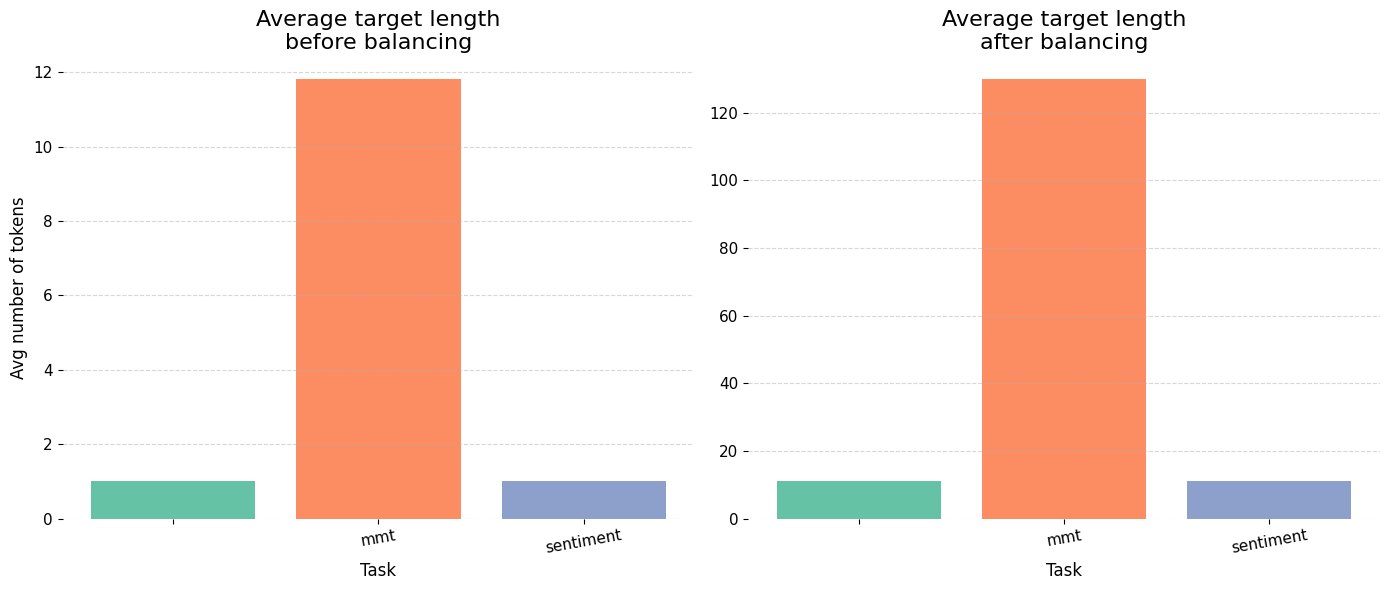

In [31]:
multitask.plot_target_lengths(train_df_no_aug, balanced_df)

In [ ]:
balanced_trainer = multitask.setup_trainer(
    model=model,
    dataset=balanced_dataset,
    tokenizer=tokenizer,
    output_dir="./sft_model/balanced_xnli_target"
)
balanced_trainer.train()

Applying formatting function to train dataset:   0%|          | 0/1883 [00:00<?, ? examples/s]

Converting train dataset to ChatML:   0%|          | 0/1883 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/1883 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1883 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1883 [00:00<?, ? examples/s]

Step,Training Loss
10,1.485600
20,1.331000
30,1.411000
40,1.710800
50,1.150400
60,1.252100
70,1.185900
80,1.320200
90,1.292600
100,1.329700


TrainOutput(global_step=351, training_loss=0.8048567777006035, metrics={'train_runtime': 956.7045, 'train_samples_per_second': 5.905, 'train_steps_per_second': 0.367, 'total_flos': 2380400228524032.0, 'train_loss': 0.8048567777006035})

In [ ]:
output_dir = '/content/drive/MyDrive/InkubaLM/outputs/'

In [ ]:
model.save_pretrained(os.path.join(output_dir, "sft_model/balanced/lora_adapter_v4"))
tokenizer.save_pretrained(os.path.join(output_dir, "sft_model/balanced/lora_adapter_v4"))


('/content/drive/MyDrive/InkubaLM/outputs/sft_model/balanced/lora_adapter_v4/tokenizer_config.json',
 '/content/drive/MyDrive/InkubaLM/outputs/sft_model/balanced/lora_adapter_v4/special_tokens_map.json',
 '/content/drive/MyDrive/InkubaLM/outputs/sft_model/balanced/lora_adapter_v4/tokenizer.model',
 '/content/drive/MyDrive/InkubaLM/outputs/sft_model/balanced/lora_adapter_v4/added_tokens.json',
 '/content/drive/MyDrive/InkubaLM/outputs/sft_model/balanced/lora_adapter_v4/tokenizer.json')

In [ ]:
from datasets import concatenate_datasets

# Combine the tuple into a list
test_dataset_list = list(test_dataset)

# Concatenate all the datasets into one
combined_test_dataset = concatenate_datasets(test_dataset_list)

In [ ]:
combined_test_dataset

Dataset({
    features: ['ID', 'task', 'langs', 'data_source', 'instruction', 'inputs', 'targets', 'premise'],
    num_rows: 900
})

In [ ]:
v2_path = os.path.join(output_dir, "sft_model/balanced_supp/checkpoint-351-v4")
os.makedirs(v2_path, exist_ok=True)
inference_model = model.eval()
results_df = multitask.apply_inference_to_test_data_xnli_change(inference_model, tokenizer, combined_test_dataset)


Generating responses:   0%|          | 0/900 [00:00<?, ?it/s]

In [ ]:
results_df[['ID', 'Response']].to_csv(os.path.join(output_dir,'submission_full_finetune_v4.csv'), index=False)
results = results_df[['ID', 'generated','Response']]

In [ ]:

from google.colab import files

# Save your CSV
output_path = os.path.join(output_dir, 'submission_full_finetune_v4.csv')
results_df[['ID', 'Response']].to_csv(output_path, index=False)

# Download the file
files.download(output_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
submission_csv = results_df[['ID','Response']]